In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import string
#https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure
import six



In [2]:
datapath = "/Users/aavattikutis/Documents/epidemicmodel/cccruns/fits/fit2/tables/"
models = ["fulllinearmodel_fit_table.csv","reducedlinearmodelNegBinom_fit_table.csv",
          "reducedlinearmodelq0_fit_table.csv","reducedlinearmodelq0ctime_fit_table.csv",
         "nonlinearmodelq0ctime_fit_table.csv","nonlinearmodel_fit_table.csv"]
model_hash = {}
k = -1
for model in models:
    k += 1
    model_hash[model] = string.ascii_uppercase[k]

df = pd.DataFrame.from_dict(model_hash, orient='index')
df.to_csv('../postfit_derivatives/model_hash.csv', header=False)

In [3]:
rois = []
for model in models:
    df = pd.read_csv(datapath + model) #get rois in all tables (some may have failed)
    rois += list(df.roi.unique())

    
rois = list(set(rois))

#get inferred
theta = df.columns[2:] 
ntheta = len(theta)



In [4]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
 

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
             
roi_us = np.sort([i for i in rois if i[:2]=='US'])#[::-1]
roi_other = np.sort([i for i in rois if i[:2]!='US'])#[::-1]
# roi_other = np.sort(pd.read_csv("../postfit_derivatives/top25.csv").values[:,0])
rois = list(roi_us) + list(roi_other)

dfwaic = pd.DataFrame(columns=['roi', 'model', 'waic'])

k = 0
for roi in rois:
#     print(roi)
    for model in models:
        k += 1
        df = pd.read_csv(datapath + model)
        try:
            measure = df.loc[(df.roi==roi)&(df['quantile']==0.5),'waic'].values[0]
#             dfwaic.loc[k] = [roi,model_hash[model],measure]
            dfwaic.loc[k] = [roi,model,measure]
        except:
#             dfwaic.loc[k] = [roi,model_hash[model],1e6]
            dfwaic.loc[k] = [roi,model,1e6]

# print(dfwaic)

In [5]:
dfwaic_sorted = dfwaic.sort_values(['waic'],ascending=True).groupby('roi')
# print(dfwaic_sorted.head())
# dfwaic_sorted = dfwaic_sorted.head().reset_index(drop=True)
dfwaic_sorted = dfwaic_sorted.head(1)

In [6]:

dfreport = pd.DataFrame(columns=['Region', 'Model','median CAR (week=0)','CI lower','CI upper','median CAR current','CI lower','CI upper','delta weeks','Mean WAIC'])
k = -1
for roi in rois:
    k += 1
    model = "fulllinearmodel_fit_table.csv" #dfwaic_sorted.loc[dfwaic_sorted.roi==roi,'model'].values[0]
    df = pd.read_csv(datapath + model)
    theta = "car (week 0)"
    measure1 = df.loc[(df.roi==roi)&(df['quantile']==0.5),theta].values[0]
    measure2 = df.loc[(df.roi==roi)&(df['quantile']==0.025),theta].values[0]
    measure3 = df.loc[(df.roi==roi)&(df['quantile']==0.975),theta].values[0]
    waic = dfwaic_sorted.loc[dfwaic_sorted.roi==roi,'waic'].values[0]
    x = [roi,model.split('_fit_table.csv')[0],np.round(measure1,4),np.round(measure2,4),np.round(measure3,4)]
    #find latest week with data
#     maxweek = 11
    for i in np.arange(11,0,-1):
        theta = 'car (week '+str(i)+')'
        x2 = df.loc[(df.roi==roi)&(df['quantile']==0.5),theta].values[0]
        if np.isfinite(x2):
#             print(x2)
            measure1 = df.loc[(df.roi==roi)&(df['quantile']==0.5),theta].values[0]
            measure2 = df.loc[(df.roi==roi)&(df['quantile']==0.025),theta].values[0]
            measure3 = df.loc[(df.roi==roi)&(df['quantile']==0.975),theta].values[0]
            x += [np.round(measure1,4),np.round(measure2,4),np.round(measure3,4),i,np.round(waic,2)]
            break
    try:
        dfreport.loc[k] = x
    except:
        print(roi)
    


Gambia


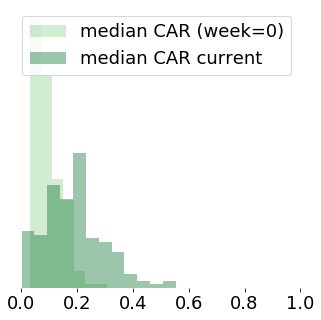

In [7]:
c_ = sns.color_palette('Greens')
f,ax = plt.subplots(1,1,figsize=(5,5))
sns.distplot(dfreport['median CAR (week=0)'],color = c_[2],ax=ax, kde=False, norm_hist=True, label='median CAR (week=0)')
sns.distplot(dfreport['median CAR current'],color = c_[5],ax=ax, kde=False, norm_hist=True,label='median CAR current')
ax = plt.gca()
ax.set_xlim((0,1))
plt.legend()
simpleaxis(ax)
# ax.set_title(label,fontsize=fs)
# ax.axvline(mu)
# ax.text(mu,20,str(np.round(mu,3)))
ax.get_yaxis().set_visible(False)
ax.set_xlabel('')
plt.subplots_adjust(hspace=0.5,bottom=0.1)
plt.savefig('../postfit_derivatives/carpastpresent.png')